## basic info

* 모든 데이터셋은 아시아인 남녀로 구성되어 있고 나이는 20대부터 70대까지 다양하게 분포
* 전체 사람 명 수 : 4,500 (train+eval)
    - 전체 데이터셋 중에서 60%는 학습 데이터셋. (2700)
* 한 사람당 사진의 개수: 7 - 마스크 착용 5장, 이상하게 착용(코스크, 턱스크) 1장, 미착용 1장
* 이미지 크기: (384, 512)
* 마스크 착용여부, 성별, 나이를 기준으로 총 18개의 클래스가 있다. 결과값으로 0~17에 해당되는 숫자가 각 이미지 당 하나씩 나와야 한다.
    - [클래스 및 추가 정보 확인](https://stages.ai/competitions/74/data/training)

## load data

### pandas dataframe 으로 데이터를 로드

In [16]:
import pandas as pd

In [21]:
train_path = '/opt/ml/input/data/train/'
data = pd.read_csv (train_path+"train.csv")
data.head(6)

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
5,000007,female,Asian,58,000007_female_Asian_58


### 학습 데이터는 2700개

In [52]:
len(data)

2700

## data preprocessing

### age 를 3개의 범위로 카테고리화 
새로운 age_category 라는 column 을 생성함
* low: <30 
* mid: >=30 and <60
* high: >=60

In [29]:
print(data['age'].max(),data['age'].min())

60 18


In [68]:
data['age_category'] = pd.cut(data['age'], bins=[0, 29, 59, 100], include_lowest=False, labels=['low', 'mid', 'high'])
data.head(3)

,id,gender,race,age,path,age_category
0,000001,female,Asian,45,000001_female_Asian_45,mid
1,000002,female,Asian,52,000002_female_Asian_52,mid
2,000004,male,Asian,54,000004_male_Asian_54,mid


In [69]:
data.tail(3)

,id,gender,race,age,path,age_category
2697,006956,male,Asian,19,006956_male_Asian_19,low
2698,006957,male,Asian,20,006957_male_Asian_20,low
2699,006959,male,Asian,19,006959_male_Asian_19,low


In [70]:
data2 = data[['id','gender','race','path','age_category']]

## EDA

### 성별에 따라 그룹화. 
- 여성이 남성보다 1.5배 많음

In [143]:
data2.groupby(['gender']).id.count()

gender
female    1658
male      1042
Name: id, dtype: int64

### 나이 카테고리에 따라 그룹화. 
- 'high' 카테고리는 오직 60세로만 이루어짐. 또한 매우 적음.
- 'low' 와 'middle' 은 서로 비슷함.

In [115]:
data2.groupby(['age_category']).id.count()

age_category
low     1281
mid     1227
high     192
Name: id, dtype: int64

In [105]:
data.loc[data['age']==60]['id'].count()

192

### 18개의 각 클래스별로 이미지 개수를 확인.

- Gender: Male / Female
- Age: <30 / >=30 and <60 / >=60
- Mask: Wear / Incorrect / Not Wear

각 path별로 마스크 착용(Wear) 5장, 이상하게 착용(Incorrect) 1장, 미착용 (Not Wear) 1장의 사진 존재.

In [99]:
data_group = data2.groupby(['age_category','gender']).count()
data_group

id  race  path
age_category gender                 
low          female  732   732   732
             male    549   549   549
mid          female  817   817   817
             male    410   410   410
high         female  109   109   109
             male     83    83    83

In [132]:
data_group2 = data_group
data_group2['wear'] = data_group2['id']*5
data_group2['incorrect'] = data_group2['id']
data_group2['notwear'] = data_group2['id']

### 아래는 최종 그룹화 결과
* 청년,중년 > 마스크 쓴 >여성 순으로 영향력 있다.
    * 청년,중년 > 노년
    * 마스크 쓴거 > 잘못쓴거=안쓴거
    * 여성 > 남성

In [133]:
data_group2 = data_group2[['wear','incorrect','notwear']]
data_group2

wear  incorrect  notwear
age_category gender                          
low          female  3660        732      732
             male    2745        549      549
mid          female  4085        817      817
             male    2050        410      410
high         female   545        109      109
             male     415         83       83

* 위 결과를 그래프로 그려본다

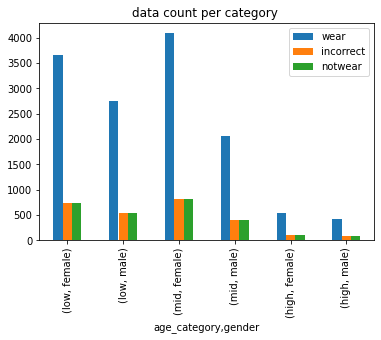

In [140]:
data_group2.plot(kind='bar',title='data count per category ')